# Second Task: Data Transformation

We start by performing **Data Cleaning** before the other subtasks in order to enhance data quality and consistency of our data. 

### Import of the needed libraries and the dataset

In [273]:
import warnings
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import unidecode

from collections import defaultdict
from scipy.stats import pearsonr

import os

cyclists = pd.read_csv('./dataset/cyclists.csv')
races = pd.read_csv('./dataset/races.csv')

## Data Cleaning

The decisions made are about handling missing values, typing casting, checking data consistency and removing unnecessary attributes (if any).

This approach ensures that both datasets are prepared for accurate and meaningful insights in the subsequent stages of our project.

### Cyclists dataset

#### Handle Missing Values and Type Casting

As seen, there is almost half of the values being null about *weight* and *height*; in the following, we print some insights to better understand.

Our initial idea was to infer *height* from *weight* (and vice versa) when only one of the two was missing. 

However, as printed, out of 2984 null values for *weight* and *height*, only 79 rows have one of the two being null.

Then, to avoid altering the data distribution, we filled them with the median. 

For what concerns *nationality*, we updated manually the single row with a null nationality value to avoid discrepancies with the races dataset.

In [274]:
count_hnn_wnn = cyclists[(cyclists['height'].isnull()) & (cyclists['weight'].isnull())].shape[0]
count_hn_wnn = cyclists[(cyclists['height'].isnull()) & (cyclists['weight'].notnull())].shape[0]
count_hnn_wn = cyclists[(cyclists['weight'].isnull()) & (cyclists['height'].notnull())].shape[0]

print(f"Number of cyclist with height and weight null: {count_hnn_wnn}")
print(f"Number of cyclist with height null and weight not null: {count_hn_wnn}")
print(f"Number of cyclist with height not null and weight null: {count_hnn_wn}")

Number of cyclist with height and weight null: 2984
Number of cyclist with height null and weight not null: 7
Number of cyclist with height not null and weight null: 72


In [275]:
#Fill weight and height with median
cyclists['weight'] = cyclists['weight'].fillna(cyclists['weight'].median())
cyclists['height'] = cyclists['height'].fillna(cyclists['height'].median())

#Manually correct the single nationality null entry
cyclists.loc[cyclists['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

We cast *birth_year* from float to int. 

Before, we need to fill the null values; a strategy to do this is to compute it from *cyclist_age* from races dataset. On the other side, there are also empty values in *cyclist_age*. 
To ensure consistency between the tables, we will perform the following steps:

1. *birth_year* and *cyclist_age* are both empty: there is no way to compute the considered cyclist age; so, since they are few but not so few to fill them by hand, we fill *cyclist_age* with the median and compute corresponding value for *birth_year*

2. Do double check for discrepancies and update them.

We will complete this task in the Races dataset. We only show for now that do exist rows with both *birth_year* and *cyclist_age* being null.

In [276]:
# Take rows where 'birth_year' is null and merge with races
cyclists_empty = cyclists[cyclists['birth_year'].isnull()]
merged_data = races.merge(cyclists_empty, left_on='cyclist', right_on='_url', how='inner')

# Filter for rows where 'cyclist_age' is empty
both_empty = merged_data[merged_data['cyclist_age'].isnull()]

print(f"Number of rows with 'birth_year' and 'cyclist_age' both empty: {len(both_empty)}")


Number of rows with 'birth_year' and 'cyclist_age' both empty: 113


We conclude this section by verifying whether type casting is possible for *height* and *weight*. 

These attributes should ideally be stored as floats, but there's a possibility that the values in the dataset have been approximated and are therefore not genuine floats. 

To ensure data integrity, we check if the decimal part of these numbers is different from .0. 

Only *height* can be casted.

In [277]:
def check_non_zero_decimal_rows(attribute_name):
    # Check if the decimal part is different from .0 (i.e., non-zero decimals)
    non_zero_decimal = cyclists[attribute_name].apply(lambda x: (x % 1) != 0 if isinstance(x, float) else False)

    # Filter rows that meet the condition (both checks should be True)
    rows_with_non_zero_decimal = cyclists[float_values & non_zero_decimal]

    # Print the number of rows and optionally the rows themselves
    print(f"Rows with decimal part differing from .0 in '{attribute_name}': {len(rows_with_non_zero_decimal)}")


In [278]:
check_non_zero_decimal_rows('weight')

Rows with decimal part differing from .0 in 'weight': 15


In [279]:
check_non_zero_decimal_rows('height')

Rows with decimal part differing from .0 in 'height': 0


In [280]:
cyclists['height'] = cyclists['height'].astype(int)
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       6134 non-null   float64
 4   height       6134 non-null   int64  
 5   nationality  6134 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 287.7+ KB


#### Checking Data Consistency

Due to the presence of *name* and *_url* attributes, we can check cyclist consistency.

We removed spaces from the names and then normalized them. 

Thereafter, we checked for any discrepancies between normalized names and their corresponding URLs. 
Observing that most discrepancies were not due to incorrect associations between different cyclists, but rather the presence of middle names or minor typos, we decided to retain these inconsistencies. 

We conclude that each cyclist is still uniquely identified by their URL.

In [281]:
# Normalize the name and remove the additional spaces
cyclists['name'] = cyclists['name'].str.replace(r'\s+', ' ', regex=True).str.strip()
cyclists['name'] = cyclists['name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')


def create_url_from_name(name):
    return unidecode.unidecode(name.lower().replace(" ", "-"))

# Find the discrepancies between the name and the URL
discrepancies = cyclists[cyclists['_url'] != cyclists['name'].apply(create_url_from_name)]

# Print the discrepancies
print(discrepancies[['_url', 'name']])

                                _url                    name
19                     michal-paluta            Micha Paluta
25                      graeme-brown      Graeme Allen Brown
32                   piotr-przydzial          Piotr Przydzia
49         jesus-rodriguez-rodriguez         Jesus Rodriguez
68             iban-herrero-atienzar            Ivan Herrero
...                              ...                     ...
6093  raul-alexander-montana-herrera  Raul Alexander Montana
6112      juan-carlos-jusdado-ibanez     Juan Carlos Jusdado
6113            joseba-albizu-lizaso           Joseba Albizu
6121          jacob-hindsgaul-madsen         Jacob Hindsgaul
6129         juan-jose-martinez-diaz      Juan Jose Martinez

[618 rows x 2 columns]


#### Drop Unnecessary Columns

No column has been dropped. 

### Races dataset

#### Handle Missing Values and Type Casting

Since for the following columns we have seen that few values are null, in the numeric attributes that cannot be completed using the mean or median for their meaning (like *profile*, *climb_total*) we put the symbolic values "-1", while for the categorical ones we use the placeholder "unknown".

We only fill *points* with the median.

Moreover, we perform all the needed casting: *profile*, *climb_total*, *cyclist_age* and *points* from float to int; *date* from object to date.


In [282]:
races['profile'] = races['profile'].fillna(-1).astype(int)
races['climb_total'] = races['climb_total'].fillna(-1).astype(int)
races['cyclist_team'] = races['cyclist_team'].fillna('unknown')
races['cyclist_age'] = races['cyclist_age'].fillna(races['cyclist_age'].median()).astype(int)
races['points'] = races['points'].fillna(races['points'].median()).astype(int)
races['date'] = pd.to_datetime(races['date'])

In [283]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _url                 589865 non-null  object        
 1   name                 589865 non-null  object        
 2   points               589865 non-null  int64         
 3   uci_points           251086 non-null  float64       
 4   length               589865 non-null  float64       
 5   climb_total          589865 non-null  int64         
 6   profile              589865 non-null  int64         
 7   startlist_quality    589865 non-null  int64         
 8   average_temperature  29933 non-null   float64       
 9   date                 589865 non-null  datetime64[ns]
 10  position             589865 non-null  int64         
 11  cyclist              589865 non-null  object        
 12  cyclist_age          589865 non-null  int64         
 13  is_tarmac     

Regarding *cyclist_age*, as we mentioned, we fill *cyclist_age* with the median and compute corresponding value for *birth_year* and then double check for discrepancies and, if necessary, update them.

In [284]:
# Fill missing cyclist_age values with the median
races['cyclist_age'] = races['cyclist_age'].fillna(races['cyclist_age'].median()).astype(int)

# Iterate over cyclists with missing birth_year and calculate birth_year using cyclist_age and date
for idx, row in cyclists[cyclists['birth_year'].isnull()].iterrows():
    cyclist_url = row['_url']
    
    # Find all rows in races for the specific cyclist
    relevant_races = races[races['cyclist'] == cyclist_url]
    
    # Calculate the birth year for each row and take the first valid value
    if not relevant_races.empty:
        calculated_birth_year = (relevant_races['date'].dt.year - relevant_races['cyclist_age']).dropna().iloc[0]
        cyclists.at[idx, 'birth_year'] = calculated_birth_year

cyclists['birth_year'] = cyclists['birth_year'].astype(int)

In [285]:
# Merge the races dataset with cyclists based on '_url' (cyclist)
races_with_birth_year = races.merge(cyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')

# Calculate the estimated birth year for each cyclist
discrepancies = races_with_birth_year[races_with_birth_year.apply(
    lambda row: row['birth_year'] != (row['date'].year - row['cyclist_age']), 
    axis=1
)]

# Display the number of discrepancies found
print(f"Discrepancies found: {discrepancies.shape[0]}")

# Show cyclist name, calculated year, and birth_year
discrepancies[['cyclist', 'date', 'birth_year']].assign(calculated_birth_year = discrepancies['date'].dt.year - discrepancies['cyclist_age'])

Discrepancies found: 24


,cyclist,date,birth_year,calculated_birth_year
6495,scott-davies,2020-10-27 04:05:14,1991,1992
12865,scott-davies,2018-04-15 06:39:57,1991,1990
12972,scott-davies,2020-10-31 05:26:30,1991,1992
60389,scott-davies,2020-10-23 03:54:11,1991,1992
189206,scott-davies,2020-11-08 03:28:49,1991,1992
217425,scott-davies,2020-10-24 04:32:14,1991,1992
250596,alexandr-osipov,1986-04-23 04:47:10,1957,1958
283649,scott-davies,2018-06-13 03:56:07,1991,1990
324670,scott-davies,2020-10-29 03:41:45,1991,1992
329037,scott-davies,2020-10-21 04:02:30,1991,1992


The double check finds 24 discrepancies regarding only two cyclists: we update them with the *cyclist_age* to reach full consistency.

In [286]:
# Change the cyclyst_age in a consistent way respect to birth_year
birth_year = cyclists.loc[cyclists['_url'] == 'alexandr-osipov', 'birth_year'].values[0]

if pd.notnull(birth_year):
    for idx, row in races[races['cyclist'] == 'alexandr-osipov'].iterrows():
        calculated_age = row['date'].year - birth_year
        races.at[idx, 'cyclist_age'] = calculated_age

birth_year = cyclists.loc[cyclists['_url'] == 'scott-davies', 'birth_year'].values[0]

if pd.notnull(birth_year):
    for idx, row in races[races['cyclist'] == 'scott-davies'].iterrows():
        calculated_age = row['date'].year - birth_year
        races.at[idx, 'cyclist_age'] = calculated_age

# Merge the races dataset with cyclists based on '_url' (cyclist)
races_with_birth_year = races.merge(cyclists[['_url', 'birth_year']], left_on='cyclist', right_on='_url', how='left')

# Calculate the estimated birth year for each cyclist
discrepancies = races_with_birth_year[races_with_birth_year.apply(
    lambda row: row['birth_year'] != (row['date'].year - row['cyclist_age']), 
    axis=1
)]

# Display the number of discrepancies found
print(f"Discrepancies found: {discrepancies.shape[0]}")

Discrepancies found: 0


#### Checking Data Consistency

We check if there are discrepancies of cyclist between the two tables and, as anticipated, we handle *cyclist_age* null values and consistency with *birth_year* in cyclists tables.

In [287]:
# Handle cyclists with uppercase names
races['cyclist'] = races['cyclist'].str.lower()

# Find unique cyclist entries in each dataset
races_cyclists = races['cyclist'].unique()
cyclists_list = cyclists['_url'].unique()

# Identify cyclists in races but not in cyclists
missing_cyclists = set(races_cyclists) - set(cyclists_list)

# Display missing cyclists
print("Cyclists in 'races' but not in 'cyclists':", len(missing_cyclists))

Cyclists in 'races' but not in 'cyclists': 0


#### Drop Unnecessary Columns

We decided to drop *average_temperature* since there where too many missing values and filling them is not so easy, *is_cobbled* and *is_gravel* since the majority of the value where False (leaving only boolean *is_tarmac*) and *uci_points* that has more than half of its values missing. Through some checks we confirmed that stages either entirely lack or fully contain uci_points without partial entries; so, as *points* already provides similar, consistently populated information, *uci_points* adds little value and can be dropped. 

In [288]:
# Drop temperature column
races.drop('average_temperature', axis=1, inplace=True)

# Drop is_cobbled and is_gravel columns
races.drop(['is_cobbled', 'is_gravel'], axis=1, inplace=True)

race_uciponts_partial = races.groupby('_url')['uci_points'].transform(lambda x: x.isnull().any() and x.notnull().any()).sum()
print(f"Number of entry with partial UCi points values to derive the entire stage: {race_uciponts_partial}")

# Drop of the UCi points column
races.drop('uci_points', axis=1, inplace=True)

Number of entry with partial UCi points values to derive the entire stage: 0


## Feature engineering and novel feature definition

#### Feature 1: *BMI*

The first feature we decided to derive is BMI (Body Mass Index), which we added as a new column in the cyclists dataset. 

BMI is calculated as the weight (in kg) divided by the square of the height (in meters)

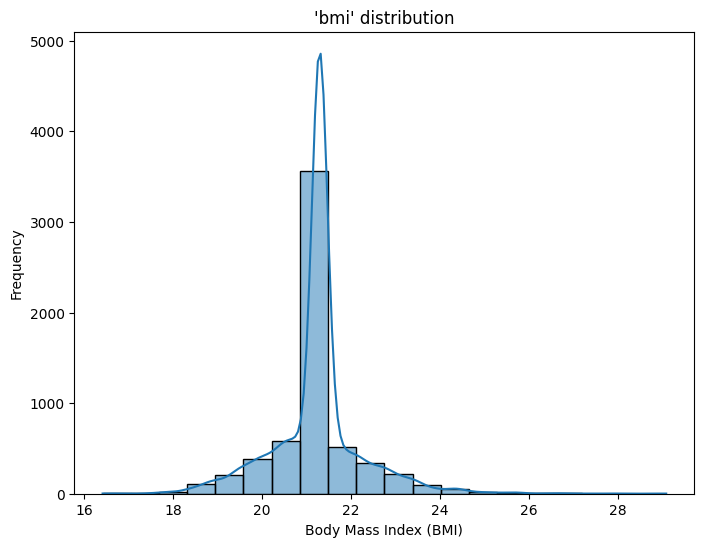

In [289]:
cyclists['bmi'] = cyclists['weight'] / (cyclists['height'] / 100) ** 2
plt.figure(figsize=(8, 6))
sns.histplot(cyclists['bmi'],bins=20, kde=True)
plt.title('\'bmi\' distribution')
plt.xlabel('Body Mass Index (BMI)')
plt.ylabel('Frequency')
plt.show()

#### Feature 2: *continent*

Next, we derive *continent* by mapping each present nationality to its belonging continent.

Percentage of Cyclists by Continent:
Europe: 85.65%
South America: 4.09%
Asia: 3.42%
North America: 3.37%
Australia: 2.69%
Africa: 0.77%


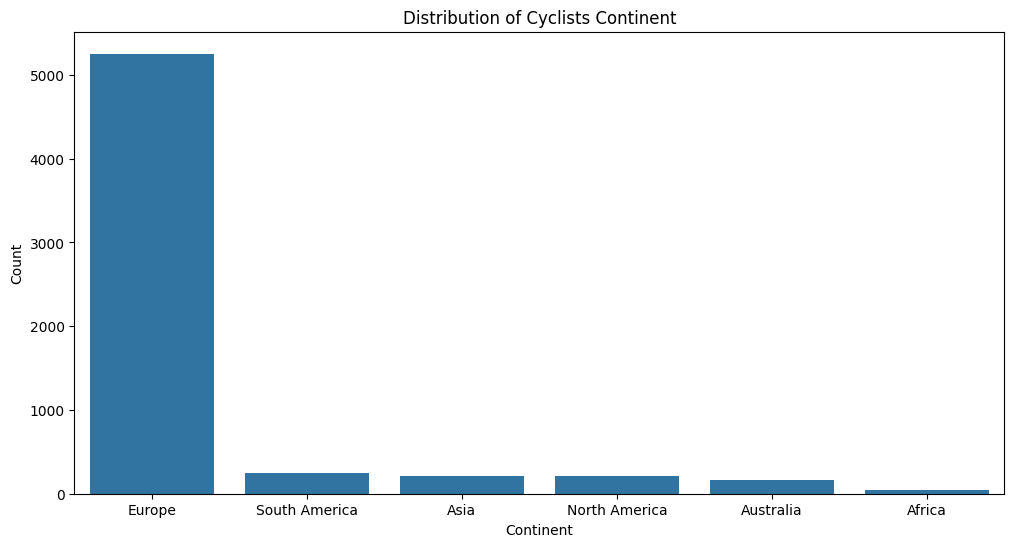

In [290]:
unique_nationalities = cyclists['nationality'].unique()

# Mapping of nationalities to continents
continent_map = {
    'Italy': 'Europe',
    'France': 'Europe',
    'Netherlands': 'Europe',
    'Belgium': 'Europe',
    'Spain': 'Europe',
    'United States': 'North America',
    'Norway': 'Europe',
    'Russia': 'Asia',
    'Poland': 'Europe',
    'Germany': 'Europe',
    'Australia': 'Australia',
    'Switzerland': 'Europe',
    'Ireland': 'Europe',
    'Denmark': 'Europe',
    'Great Britain': 'Europe',
    'Colombia': 'South America',
    'South Africa': 'Africa',
    'Argentina': 'South America',
    'New Zealand': 'Australia',
    'Lithuania': 'Europe',
    'Portugal': 'Europe',
    'Austria': 'Europe',
    'Yugoslavia': 'Europe',
    'Estonia': 'Europe',
    'Romania': 'Europe',
    'Slovenia': 'Europe',
    'Canada': 'North America',
    'Latvia': 'Europe',
    'Luxembourg': 'Europe',
    'Sweden': 'Europe',
    'Czech Republic': 'Europe',
    'Slovakia': 'Europe',
    'Morocco': 'Africa',
    'Ukraine': 'Europe',
    'Ethiopia': 'Africa',
    'Belarus': 'Europe',
    'Venezuela': 'South America',
    'Japan': 'Asia',
    'Mexico': 'North America',
    'Croatia': 'Europe',
    'Kazakhstan': 'Asia',
    'Uruguay': 'South America',
    'Israel': 'Asia',
    'Namibia': 'Africa',
    'Eritrea': 'Africa',
    'Costa Rica': 'North America',
    'Taiwan': 'Asia',
    'Azerbaijan': 'Asia',
    'Hungary': 'Europe',
    'Moldova': 'Europe',
    'Panama': 'North America',
    'Finland': 'Europe',
    'Bulgaria': 'Europe',
    'Serbia': 'Europe',
    'Brazil': 'South America',
    'Iran': 'Asia',
    'Greece': 'Europe',
    'Chile': 'South America',
    'Ecuador': 'South America',
    'China': 'Asia',
    'Albania': 'Europe',
    'Guatemala': 'North America',
    'Uzbekistan': 'Asia',
    'Algeria': 'Africa',
    'Tunisia': 'Africa',
    'Monaco': 'Europe',
    'Rwanda': 'Africa',
    'Dominican Republic': 'North America',
    'Liechtenstein': 'Europe',
    'Zimbabwe': 'Africa',
    'Puerto Rico': 'North America',
    'Hongkong': 'Asia',
}

# Map the 'nationality' column to the new 'continent' column
cyclists['continent'] = cyclists['nationality'].map(continent_map)

# Calculate the percentage of cyclists from each continent
continent_percentage = cyclists['continent'].value_counts(normalize=True) * 100
print("Percentage of Cyclists by Continent:")
for continent, percentage in continent_percentage.items():
    print(f"{continent}: {percentage:.2f}%")

plt.figure(figsize=(12, 6))
sns.countplot(data=cyclists, x='continent', order=cyclists['continent'].value_counts().index)
plt.title('Distribution of Cyclists Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()

#### Feature 3: *avg_position* (and *avg_delta*)

As last features for cyclists, we introduce *avg_position* for further computations in the clustering task.

We will introduce also *avg_delta*, but first we have to clean *delta* from the outliers.

!!! PERCHE INFATTI NON HANNO MAI GAREGGIATO
Since there are a few cyclists non-corresponding between the two datasets, we fill the missing values with the median.

In [291]:
# Add the feature 'avg_position' in cyclists
cyclists = cyclists.merge(races.groupby('cyclist', as_index=False)['position'].mean(), left_on='_url', right_on='cyclist', how='left')
cyclists.rename(columns={'position': 'avg_position'}, inplace=True)

# Fill the missing values in 'avg_position' with the median
cyclists['avg_position'] = cyclists['avg_position'].fillna(cyclists['avg_position'].median())

# Drop of cyclist column
cyclists.drop('cyclist', axis=1, inplace=True)

# Cast the 'avg_position' column to integer
cyclists['avg_position'] = cyclists['avg_position'].astype(int)

#### Feature 4: *season*

Now, moving on to the races dataset, we decided to add a feature representing the four seasons to better categorize the time of year in which each race took place.

Percentage of Races for season:
spring: 43.09%
summer: 41.80%
autumn: 13.92%
winter: 1.19%


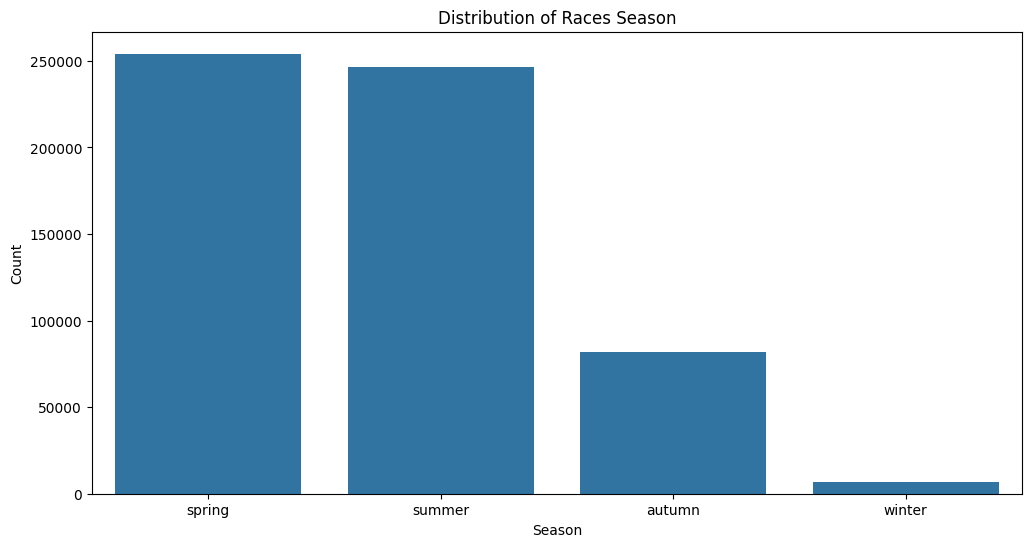

In [292]:
# Create 'month' and 'season' columns
races['month'] = races['date'].dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'autumn'

races['season'] = races['month'].apply(get_season)


# Calculate the percentage of races for each season
season_percentage = races['season'].value_counts(normalize=True) * 100
print("Percentage of Races for season:")
for season, percentage in season_percentage.items():
    print(f"{season}: {percentage:.2f}%")

plt.figure(figsize=(12, 6))
sns.countplot(data=races, x='season', order=races['season'].value_counts().index)
plt.title('Distribution of Races Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()


#### Feature 5: *race_intensity* 

The *race_intensity* feature is computed as a weighted combination of three components: first, it considers the ratio of *climb_total* to *length*, which represents the steepness of the race. Next, it incorporates the *profile* score, indicating the overall difficulty level of the terrain. Finally, a logarithmic transformation of *length* is applied to capture the effect of distance on race intensity.

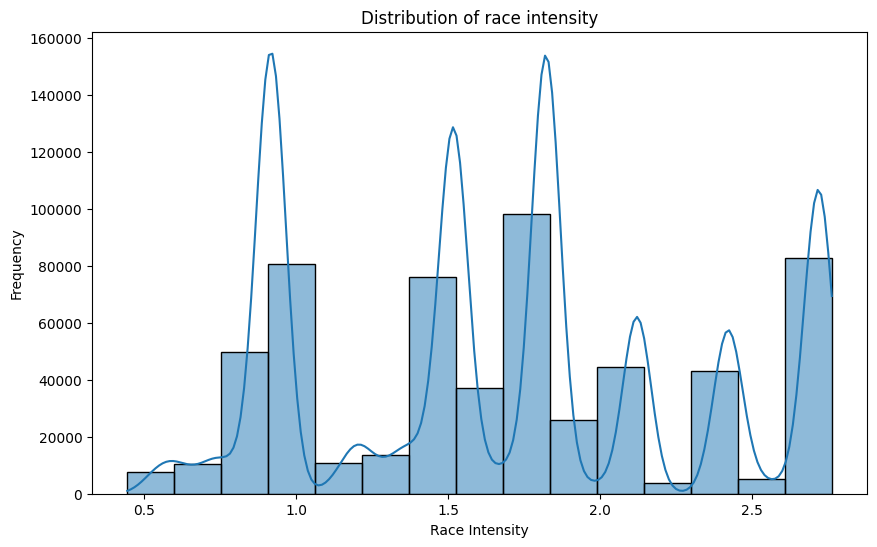

In [293]:
# We use a ratio of 'climb_total' to 'length', add a scaled 'profile', and apply a logarithmic transformation to 'length'
races['race_intensity'] = 0.6 * (races['climb_total'] / races['length']) + 0.3 * races['profile'] + 0.1 * races['length'].apply(math.log)
plt.figure(figsize=(10, 6))
sns.histplot(races['race_intensity'],bins=15, kde=True)
plt.title('Distribution of race intensity')
plt.xlabel('Race Intensity')
plt.ylabel('Frequency')
plt.show()

Our datasets have been completed (meaning no null values are present) and cleaned.

In [294]:
cyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _url          6134 non-null   object 
 1   name          6134 non-null   object 
 2   birth_year    6134 non-null   int64  
 3   weight        6134 non-null   float64
 4   height        6134 non-null   int64  
 5   nationality   6134 non-null   object 
 6   bmi           6134 non-null   float64
 7   continent     6134 non-null   object 
 8   avg_position  6134 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 431.4+ KB


In [295]:
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589865 non-null  object        
 1   name               589865 non-null  object        
 2   points             589865 non-null  int64         
 3   length             589865 non-null  float64       
 4   climb_total        589865 non-null  int64         
 5   profile            589865 non-null  int64         
 6   startlist_quality  589865 non-null  int64         
 7   date               589865 non-null  datetime64[ns]
 8   position           589865 non-null  int64         
 9   cyclist            589865 non-null  object        
 10  cyclist_age        589865 non-null  int64         
 11  is_tarmac          589865 non-null  bool          
 12  cyclist_team       589865 non-null  object        
 13  delta              589865 non-null  float64 

## Outlier detection

Since we completed the first subtask introducing the new features, we can carry on with the outlier detection task. 

Starting with the numerical values, we decide to use the two principal techniques for our purpose: *Z-score* for the data with roughly normal distribution and *Interquartile Range (IQR)* method for all the others. They are implemented in the following block to be re-used.

In [296]:
# Definition of the two function for the outliers detection

# Interquartile range method
def detect_outliers_iqr(data, column):
    # Calculate the first (Q1) and third (Q3) quartiles
    Q1 = data[column].quantile(0.25)  # 25th percentile
    Q3 = data[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1                     # Interquartile range
    
    # Determine the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers as values outside the lower and upper bounds
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    # Calculate the Z-scores for the specified column
    z_scores = stats.zscore(data[column])
    
    # Identify outliers based on the specified threshold (default is 3)
    outliers = data[abs(z_scores) > threshold]
    return outliers

### Cyclists dataset

For *birth_year* we employ IQR, because the already seen distribution isn't a normal one. 

There aren't anomalous value.

In [297]:
detect_outliers_iqr(cyclists, 'birth_year')

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position


For *weight*, *height* and *bmi* features, we adopt Z-score method. 

For the first two, the returned few values are not unlikely (also for professional cyclists), so we don't modify them. 

Some interesting values come out from *bmi* feature; compared with the BMI scale, the values under 18 are underweight and over 25 are overweight. 

Althought this, we do not modify the dataset since, even if they are athletes, these values are normally likely. 

In [298]:
detect_outliers_zscore(cyclists, 'weight', threshold=5)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
4554,gerrit-solleveld,Gerrit Solleveld,1961,93.0,183,Netherlands,27.770313,Europe,113
5490,soren-waerenskjold,Sren Wrenskjold,2000,92.0,195,Norway,24.194609,Europe,93
5913,magnus-backstedt,Magnus Backstedt,1975,94.0,194,Sweden,24.976087,Europe,84


In [299]:
detect_outliers_zscore(cyclists, 'height', threshold=5)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
679,conor-dunne,Conor Dunne,1992,88.0,204,Ireland,21.145713,Europe,134
720,vicente-belda,Vicente Belda,1954,69.0,154,Spain,29.094282,Europe,49
1818,alfons-de-bal,Alfons De Bal,1943,69.0,155,Belgium,28.720083,Europe,14


In [300]:
detect_outliers_zscore(cyclists, 'bmi', threshold=4)

,_url,name,birth_year,weight,height,nationality,bmi,continent,avg_position
720,vicente-belda,Vicente Belda,1954,69.0,154,Spain,29.094282,Europe,49
857,jon-ander-insausti,Jon Ander Insausti,1992,89.0,187,Spain,25.451114,Europe,54
1067,daniel-arroyave-canas,Daniel Arroyave,2000,52.0,178,Colombia,16.412069,South America,133
1352,michael-friedman,Michael Friedman,1982,82.0,175,United States,26.775510,North America,117
1487,michael-kolar,Michael Kolar,1992,90.0,185,Slovakia,26.296567,Europe,115
1534,john-degenkolb,John Degenkolb,1989,82.0,180,Germany,25.308642,Europe,80
1818,alfons-de-bal,Alfons De Bal,1943,69.0,155,Belgium,28.720083,Europe,14
2192,javier-francisco-elorriaga,Javier Francisco Elorriaga,1947,85.0,179,Spain,26.528510,Europe,38
2250,paulino-martinez,Paulino Martinez,1952,80.0,176,Spain,25.826446,Europe,81
3174,massimiliano-mori,Massimiliano Mori,1974,77.0,174,Italy,25.432686,Europe,88


### Races dataset

For the *points* entry in races, we don't perform any method since we have different range of values unrelated between them and so it isn't meaningful to search for outliers.

For the *length* feature, due to its asymmetric and multimodal distribution, we opt for the IQR method.
Although this approach flagged numerous data points as potential outliers, we choose to retain them since they were neither improbable, negative, nor unrealistically large.

In [301]:
outlier_iqr_length = detect_outliers_iqr(races, 'length')

outlier_iqr_length.drop_duplicates(subset='_url')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
426,volta-a-catalunya/1999/prologue,Volta Ciclista a Catalunya,50,8100.0,-1,-1,804,1999-06-17 00:10:12,0,angel-luis-casero,27,True,euskaltel-euskadi-2010,0.0,6,summer,0.599888
866,tour-de-france/1978/stage-14,Tour de France,100,52000.0,1351,5,1241,1978-07-14 01:25:51,0,joop-zoetemelk,32,True,spain-1991,0.0,7,summer,2.601488
1075,volta-a-catalunya/1981/stage-2b,Volta Ciclista a Catalunya,50,30000.0,-1,-1,388,1981-09-05 00:44:24,0,aad-van-den-hoek,30,True,unknown,0.0,9,autumn,0.730875
1084,paris-nice/1994/stage-8b,Paris - Nice,50,12500.0,-1,-1,900,1994-03-13 00:22:06,0,tony-rominger,33,True,ag2r-prevoyance-2001,0.0,3,spring,0.643300
1483,milano-sanremo/2004/result,Milano-Sanremo,275,294000.0,-1,-1,1400,2004-03-20 07:11:23,0,oscar-freire,28,False,kazakhstan-2022,0.0,3,spring,0.959131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585303,milano-sanremo/2019/result,Milano-Sanremo,275,291000.0,2060,2,1171,2019-03-23 06:40:14,0,julian-alaphilippe,27,False,del-tongo-1986,0.0,3,spring,1.862355
585665,tour-de-france/1990/stage-5,Tour de France,100,301000.0,3365,1,1959,1990-07-04 07:43:07,0,gerrit-solleveld,29,True,liberty-seguros-wurth-team-2005,0.0,7,summer,1.568194
585859,milano-sanremo/1996/result,Milano-Sanremo,275,294000.0,-1,-1,1580,1996-03-23 07:00:27,0,gabriele-colombo,24,False,rally-cycling-2021,0.0,3,spring,0.959131
587372,vuelta-a-espana/1997/stage-21,Vuelta a España,80,43000.0,477,-1,1165,1997-09-27 00:51:35,0,alex-zulle,29,True,germany-2004,0.0,9,autumn,0.773551


For the same reason as above, the IQR method was also applied to *climb_total*. 

No outlier comes out.

In [302]:
detect_outliers_iqr(races, 'climb_total')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity


Regarding *cyclist_age*, a more thorough analysis was conducted by applying both the IQR and Z-score methods. 

The first observation is that, since these values are consistent with *birth_year* in the cyclists dataset, they all appear plausible.

Nonetheless, the IQR method highlighted over 4,000 entries corresponding to around a hundred cyclists with ages that are outside the typical range (particularly those over 40 years old). On the other hand, the Z-score method, with an appropriate threshold, finds only one cyclist.

In [303]:
outlier_iqr_cyclist_age = detect_outliers_iqr(races, 'cyclist_age')

print(f"{len(outlier_iqr_cyclist_age['cyclist'].unique())}")

outlier_zs_cyclist_age = detect_outliers_zscore(races, 'cyclist_age', threshold=5)

print(f"{len(outlier_zs_cyclist_age['cyclist'].unique())}")

112
1


In [304]:
outlier_iqr_cyclist_age

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
111,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 05:44:13,5,haimar-zubeldia,39,True,linea-md-italia-maggi-mobili-1985,49.0,9,autumn,2.735653
129,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 05:46:35,23,jean-christophe-peraud,39,True,kazakhstan-2019,191.0,9,autumn,2.735653
241,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:22:05,135,svein-tuft,39,True,unknown,2321.0,9,autumn,2.735653
287,tour-de-france/2019/stage-21,Tour de France,100,128000.0,781,1,1699,2019-07-28 03:04:08,16,alejandro-valverde,39,True,netherlands-1974,0.0,7,summer,1.479639
359,tour-de-france/2019/stage-21,Tour de France,100,128000.0,781,1,1699,2019-07-28 03:04:45,88,lars-ytting-bak,39,True,team-giant-shimano-2014,37.0,7,summer,1.479639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589598,volta-a-catalunya/2016/stage-7,Volta Ciclista a Catalunya,50,136400.0,1880,2,1045,2016-03-27 03:16:14,56,haimar-zubeldia,39,True,linea-md-italia-maggi-mobili-1985,161.0,3,spring,1.790604
589617,volta-a-catalunya/2016/stage-7,Volta Ciclista a Catalunya,50,136400.0,1880,2,1045,2016-03-27 03:19:20,75,paolo-tiralongo,39,True,ceramica-panaria-navigare-2007,347.0,3,spring,1.790604
589746,giro-d-italia/2010/stage-1,Giro d'Italia,80,8400.0,60,1,878,2010-05-08 00:10:54,78,alessandro-bertolini,39,True,team-saxo-bank-tinkoff-bank-2012,36.0,5,spring,1.207884
589764,giro-d-italia/2010/stage-1,Giro d'Italia,80,8400.0,60,1,878,2010-05-08 00:11:00,96,inigo-cuesta,41,True,unknown,42.0,5,spring,1.207884


In [305]:
outlier_zs_cyclist_age

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
114525,vuelta-a-espana/1996/stage-1,Vuelta a España,80,162000.0,862,-1,988,1996-09-07 03:52:27,129,jose-azevedo-goncalves,56,True,unknown,0.0,9,autumn,0.902728


We can confirmed what was observed in the preliminary analysis: the presence of two cyclists with notably unusual ages, 13 and 56 years. We have decided to leave them in the dataset as they are for now.

In [306]:
races[((races['cyclist_age'] < 17) | (races['cyclist_age'] > 45))]

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
114525,vuelta-a-espana/1996/stage-1,Vuelta a España,80,162000.0,862,-1,988,1996-09-07 03:52:27,129,jose-azevedo-goncalves,56,True,unknown,0.0,9,autumn,0.902728
294489,san-sebastian/2001/result,Clasica Ciclista San Sebastian,225,227000.0,-1,2,1048,2001-08-11 05:28:57,91,plamen-stanev,13,False,unknown,663.0,8,summer,1.833268


Moving on to the *delta* analysis, the first step was to check for values below zero. 

It was decided to replace these negative values with those of the preceding rows to maintain the consistency of an increasing delay for increasing positiona.

A cyclist should not have a smaller delay than the one before them, so this correction helps prevent data anomalies. 

Subsequently, the IQR method was applied, confirming that no further modifications or removals were needed, as the data fell within a reasonable threshold.

In [307]:
races[races['delta'] < 0]

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
70651,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:02:23,10,johan-bruyneel,28,True,ville-de-charleroi-new-systems-2000,-2635.0,5,spring,0.758925
70652,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:02:20,11,raul-alcala,28,True,team-volksbank-2008,-2638.0,5,spring,0.758925
70653,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:57,12,joachim-halupczok,24,True,unknown,-2541.0,5,spring,0.758925
70654,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:56,13,djamolidine-abduzhaparov,28,True,south-africa-2022,-2542.0,5,spring,0.758925
70655,vuelta-a-espana/1992/stage-19,Vuelta a España,80,37900.0,294,-1,1033,1992-05-15 00:03:53,14,guido-bontempi,32,True,south-africa-2022,-2545.0,5,spring,0.758925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229670,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:55:03,7,laurent-jalabert,22,True,kazakhstan-2022,-5562.0,3,spring,0.853267
229671,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:55:03,8,claudio-chiappucci,27,True,csf-group-navigare-2008,-5562.0,3,spring,0.853267
229672,paris-nice/1990/stage-7a,Paris - Nice,50,102000.0,-1,-1,995,1990-03-11 00:32:39,9,jean-claude-colotti,29,True,jolly-ceramica-1977,-6906.0,3,spring,0.853267
413492,tour-de-france/2003/stage-12,Tour de France,100,47000.0,712,2,1688,2003-07-18 00:09:35,104,leonardo-bertagnolli,25,True,team-saxo-bank-tinkoff-bank-2012,-2937.0,7,summer,1.684880


In [308]:
# Sobstitute the negative values with the previous value
races['delta'] = races['delta'].mask(races['delta'] < 0).ffill()

detect_outliers_iqr(races, 'delta')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity
178,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,72,axel-domont,26,True,kazakhstan-2019,1620.0,9,autumn,2.735653
179,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,73,clement-chevrier,24,True,mexico-1986,1620.0,9,autumn,2.735653
180,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,74,odd-christian-eiking,22,True,canada-1996,1620.0,9,autumn,2.735653
181,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,75,koen-bouwman,23,True,new-zealand-1991,1620.0,9,autumn,2.735653
182,vuelta-a-espana/2016/stage-14,Vuelta a España,80,196000.0,5575,5,821,2016-09-03 06:10:24,76,merhawi-kudus,22,True,ireland-2005,1620.0,9,autumn,2.735653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589197,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,177,francesco-reda,28,True,spain-1991,1954.0,7,summer,2.726493
589198,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,178,serge-pauwels,27,True,o.n.c.e.-deutsche-bank-2000,1954.0,7,summer,2.726493
589199,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,179,stephen-cummings,29,True,o.n.c.e.-deutsche-bank-2000,1954.0,7,summer,2.726493
589200,tour-de-france/2010/stage-8,Tour de France,100,189000.0,3636,5,1685,2010-07-11 05:26:45,180,thor-hushovd,32,True,switzerland-1997,1954.0,7,summer,2.726493


As stated previously, we add the *avg_delta* feature.

In [309]:
# Add the feature 'avg_delta' in cyclists
cyclists = cyclists.merge(races.groupby('cyclist', as_index=False)['delta'].mean(), left_on='_url', right_on='cyclist', how='left')
cyclists.rename(columns={'delta': 'avg_delta'}, inplace=True)

# Fill the missing values in 'avg_delta' with the median
cyclists['avg_delta'] = cyclists['avg_delta'].fillna(cyclists['avg_delta'].median())

# Drop of cyclist column
cyclists.drop('cyclist', axis=1, inplace=True)
cyclists.describe()

,birth_year,weight,height,bmi,avg_position,avg_delta
count,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000,6134.000000
mean,1974.055103,68.828758,179.905282,21.257522,75.971797,442.609787
std,15.529270,4.499758,4.612879,1.002321,33.010333,243.941882
min,1933.000000,48.000000,154.000000,16.412069,0.000000,0.000000
25%,1962.000000,69.000000,180.000000,21.132713,54.000000,280.190476
50%,1974.000000,69.000000,180.000000,21.296296,78.000000,426.851259
75%,1987.000000,69.000000,180.000000,21.296296,98.000000,575.500000
max,2004.000000,94.000000,204.000000,29.094282,205.000000,2858.428571


The last numerical value to analyze is *race_intensity*. 

We have already observed that it does not follow a normal distribution, so we use the IQR method. 

As expected, there isn't outliers values, all the values are between 0,4 and 2,7.

In [310]:
detect_outliers_iqr(races, 'race_intensity')

,_url,name,points,length,climb_total,profile,startlist_quality,date,position,cyclist,cyclist_age,is_tarmac,cyclist_team,delta,month,season,race_intensity


In [311]:
races['race_intensity'].describe()

count    589865.000000
mean          1.700245
std           0.629415
min           0.443485
25%           0.960166
50%           1.790525
75%           2.126757
max           2.763630
Name: race_intensity, dtype: float64

Now that also outliers have been managed, we can save the cleaned and processed datasets.

In [312]:
cyclists.info()
cyclists.to_csv('dataset/cyclists_trasformed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   _url          6134 non-null   object 
 1   name          6134 non-null   object 
 2   birth_year    6134 non-null   int64  
 3   weight        6134 non-null   float64
 4   height        6134 non-null   int64  
 5   nationality   6134 non-null   object 
 6   bmi           6134 non-null   float64
 7   continent     6134 non-null   object 
 8   avg_position  6134 non-null   int64  
 9   avg_delta     6134 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 479.3+ KB


In [313]:
races.info()
races.to_csv('dataset/races_trasformed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _url               589865 non-null  object        
 1   name               589865 non-null  object        
 2   points             589865 non-null  int64         
 3   length             589865 non-null  float64       
 4   climb_total        589865 non-null  int64         
 5   profile            589865 non-null  int64         
 6   startlist_quality  589865 non-null  int64         
 7   date               589865 non-null  datetime64[ns]
 8   position           589865 non-null  int64         
 9   cyclist            589865 non-null  object        
 10  cyclist_age        589865 non-null  int64         
 11  is_tarmac          589865 non-null  bool          
 12  cyclist_team       589865 non-null  object        
 13  delta              589865 non-null  float64 